In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=1, maximum=40) 

ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44062 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44062/status,
Dashboard: http://127.0.0.1:44062/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42847,Workers: 8
Dashboard: http://127.0.0.1:44062/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:42612,Total threads: 8
Dashboard: http://127.0.0.1:37208/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:36437,


In [3]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=False,
)

/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [4]:
username= "wbeebe"
basedir = f"/astro/users/{username}/data/"

In [5]:
"""
0. Negative log-likelihood of the Gaussian Process model
1. log_drw_scale = theta[0]
2. log_drw_amp = theta[1]
3. log_per_scale = theta[2]
4. log_per_amp = theta[3]
"""

res_tsp_run_0 = pd.read_parquet(f"{basedir}/res_tsp_run_g_0.parquet", engine='pyarrow')
res_tsp_run_0_drw = pd.read_parquet(f"{basedir}/res_tsp_run_g_0_drw.parquet", engine='pyarrow')
# numpy version of the results
res_tsp_run_0_np = np.vstack(res_tsp_run_0.values)
# res_tsp_run_0_drw = pd.read_parquet('/astro/users/ncaplar/data/res_tsp_run_0_drw', engine='pyarrow')
# res_tsp_run_0_drw_np = np.vstack(res_tsp_run_0_drw.data.values)

In [6]:
celerite_run = pd.read_parquet(f"{basedir}/celerite/res_tsp_run_g_0.parquet", engine='pyarrow')
celerite_run_drw = pd.read_parquet(f"{basedir}/celerite/res_tsp_run_g_0_drw.parquet", engine='pyarrow')
# numpy version of the results
celerite_run_np = np.vstack(celerite_run.values)
celerite_run_drw_np = np.vstack(celerite_run_drw.values)

In [7]:
res_tsp_run_0.head(10)

,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
SDSS_NAME_dr16q_constant,,,,,,,,,
b'024050.36-003109.0',39.083982,3.088500,-0.715306,1.468924,-1.164669,1.460723,-1.409983,0.468374,-1.184457
b'024052.82-004110.9',-35.156772,-12.493350,-10.902907,2.738975,-1.331822,0.232252,-0.446263,3.155693,-2.318740
b'024126.71-004526.3',-29.632743,-10.076967,-6.401982,2.944183,-1.101969,0.780093,1.537832,3.032145,-1.003249
b'024151.76-001953.6',31.643813,2.550391,-1.240236,1.469939,-1.185938,4.436064,-0.351747,1.432706,-0.935809
b'024154.42-004757.6',-12.792812,3.320252,-1.580990,-0.159079,-2.115329,2.137705,1.485551,1.079105,-1.820266
b'024204.58-003835.7',-1.507769,-6.808425,-6.494062,1.920060,-1.181773,2.571172,1.303653,1.965489,-1.317768
b'024207.19-002818.9',-85.101692,0.927641,-15.330437,3.225085,-1.347857,0.226136,-1.811812,2.850306,-0.414367
b'024214.97-003131.8',-10.525609,0.605358,-6.851160,2.949810,-1.263522,0.325258,-2.400673,2.884519,-2.960418
b'024220.73-002059.7',-121.599400,-9.749548,-7.189480,3.300705,-0.803074,3.856352,0.454689,3.991476,-0.676593


In [8]:
ens._source.compute().loc[b"024052.82-004110.9"]

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,0.000004,102776839.0,128.0,57706560.0,6.0,10000.0,17752.0,6,10000,survey_1
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,0.000004,102776839.0,128.0,124815424.0,6.0,10000.0,17752.0,6,10000,survey_1
b'024052.82-004110.9',4996922031703326720,7825,57030,143,40.220118,-0.686367,b'7825-57030-0143',b'BOSS',0.2466,b'DR7QV_SCH',...,0.000005,102776839.0,128.0,7374912.0,6.0,10000.0,17752.0,6,10000,survey_1


In [9]:
name_str = b'024052.82-004110.9'

ts_computed = ens._source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']

ens._source.compute().loc[name_str]

ens.query("band_ztf_source == 'g'", table = 'source')
ts = ens._source.compute().loc[name_str]
t = ts['mjd_ztf_source'].values
sort_array = np.argsort(t)
t = t[sort_array]
y = ts['mag_ztf_source'].values[sort_array]
yerr = ts['magerr_ztf_source'].values[sort_array]

t_r = ts_computed_r['mjd_ztf_source'].values
y_r = ts_computed_r['mag_ztf_source'].values
yerr_r = ts_computed_r['magerr_ztf_source'].values

In [16]:
x = np.linspace(np.min(t) - 100, np.max(t) + 100, 2000)


JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
theta = celerite_run.loc[name_str][1:].values
theta_drw = celerite_run_drw.loc[name_str][1:].values

print(theta)

gp = JaxPeriodDrwFit_instance.build_gp(theta, t, y, yerr)
gp_drw = JaxPeriodDrwFit_instance.build_gp_drw(theta_drw, t, y, yerr)

cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

cond_gp_drw = gp_drw.condition(y, x).gp
mu_drw, var_drw = cond_gp_drw.loc, cond_gp_drw.variance

mu_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.loc
var_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.variance

mu_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.loc
var_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.variance

[ 1.04209697 -1.09717634  2.75681406 -1.09867232  1.87270059 -2.84285407
  3.21015823 -2.85787527]


In [19]:
print(theta)

[ 1.04209697 -1.09717634  2.75681406 -1.09867232  1.87270059 -2.84285407
  3.21015823 -2.85787527]


In [ ]:
# To optimize per one
#JaxPeriodDrwFit_instance.optimize_map(t, y, yerr, n_init = 10000)

In [11]:
res_tsp_run_0.loc[name_str]

neg_log_lh           -35.156772
log_drw_scale        -12.493350
log_drw_amp          -10.902907
log_per_scale          2.738975
log_per_amp           -1.331822
init_log_drw_scale     0.232252
init_log_drw_amp      -0.446263
init_log_per_scale     3.155693
init_log_per_amp      -2.318740
Name: b'024052.82-004110.9', dtype: float64

In [12]:
res_tsp_run_0_drw.loc[name_str]

neg_log_lh           -34.805998
log_drw_scale         -3.807629
log_drw_amp           -4.933484
init_log_drw_scale     0.979914
init_log_drw_amp       0.808098
Name: b'024052.82-004110.9', dtype: float64

In [13]:
y_r

array([17.51965 , 17.456049, 17.544926, 17.544697, 17.505909, 17.522085,
       17.440632, 17.481247, 17.547705, 17.595821, 17.528791, 17.562477,
       17.495007, 17.545456, 17.60978 , 17.624748, 17.58022 , 17.514378,
       17.596027, 17.52385 , 17.576351, 17.604134, 17.465733, 17.4548  ,
       17.446144, 17.546202, 17.596767, 17.47398 , 17.45805 , 17.476707,
       17.506542, 17.524292, 17.48819 , 17.576675, 17.395653, 17.494621,
       17.36705 , 17.487766, 17.456219, 17.568512, 17.543459, 17.584665,
       17.675259, 17.570282, 17.567116, 17.550934, 17.595097, 17.578506,
       17.58362 ], dtype=float32)

In [ ]:
# Celerite

x = np.linspace(np.min(t) - 100, np.max(t) + 100, 2000)


#JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
theta = res_tsp_run_0.loc[name_str][1:].values
theta_drw = res_tsp_run_0_drw.loc[name_str][1:].values

print(theta)

gp = JaxPeriodDrwFit_instance.build_gp(theta, t, y, yerr)
gp_drw = JaxPeriodDrwFit_instance.build_gp_drw(theta_drw, t, y, yerr)

cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

cond_gp_drw = gp_drw.condition(y, x).gp
mu_drw, var_drw = cond_gp_drw.loc, cond_gp_drw.variance

mu_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.loc
var_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.variance

mu_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.loc
var_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.variance

/tmp/ipykernel_64996/1723399926.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
/tmp/ipykernel_64996/1723399926.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')


(17.860028404279003, 18.219568693913878)

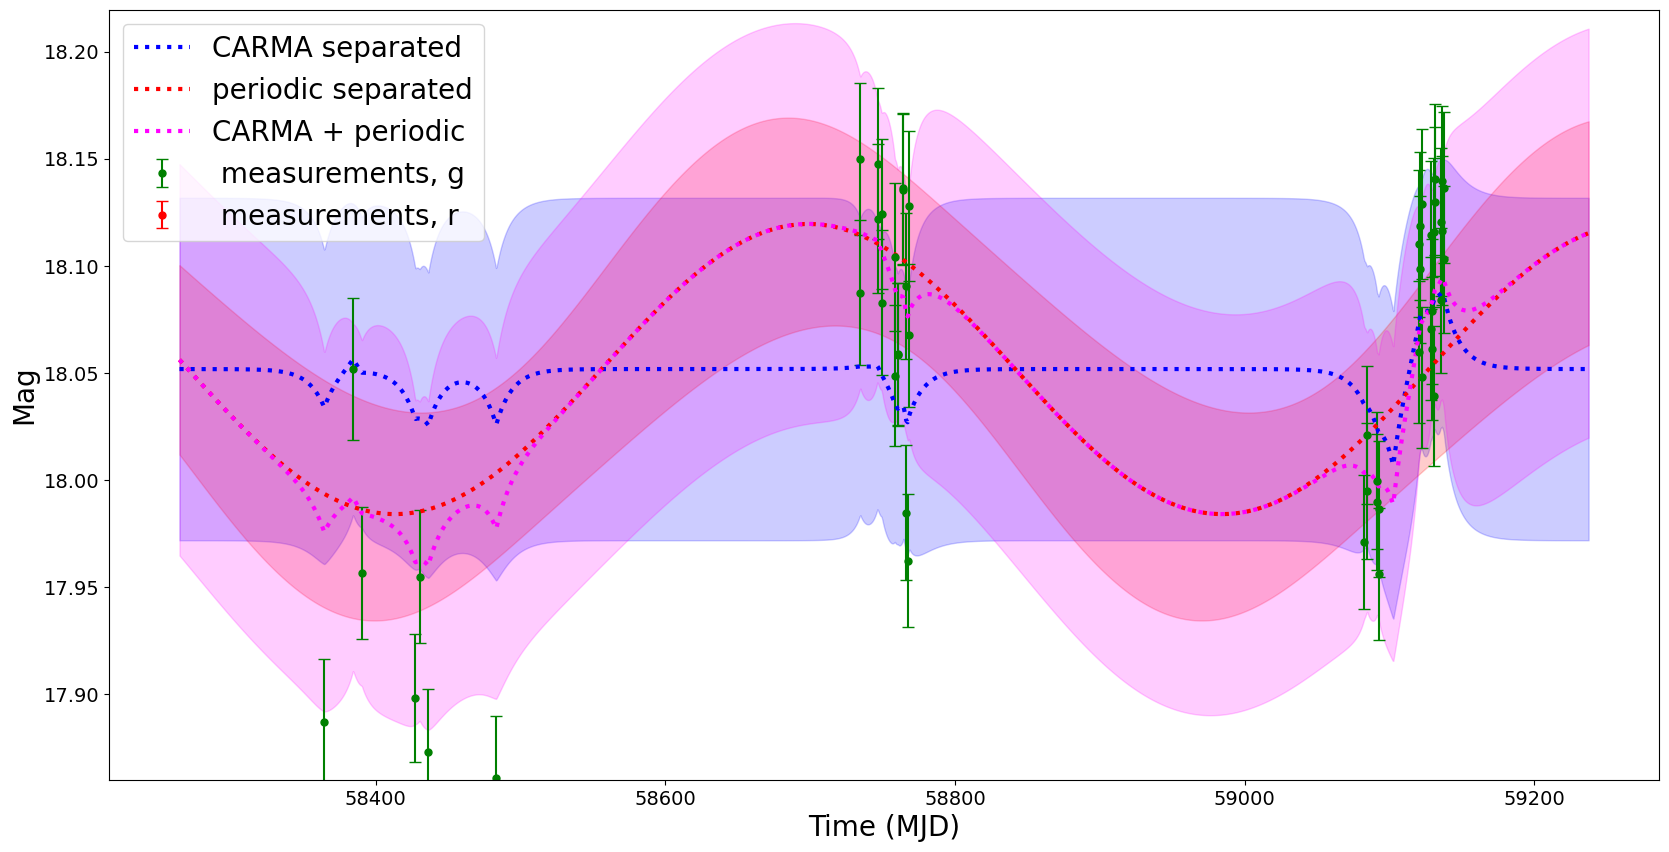

In [18]:
plt.figure(figsize=(20, 10))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("Time (MJD)", fontsize=20)
plt.ylabel("Mag", fontsize=20)
plt.legend(fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(np.min(mu)-0.1, np.max(mu)+0.1)

/tmp/ipykernel_64996/245866223.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
/tmp/ipykernel_64996/245866223.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')


Text(0.5, 1.0, 'Only DRW')

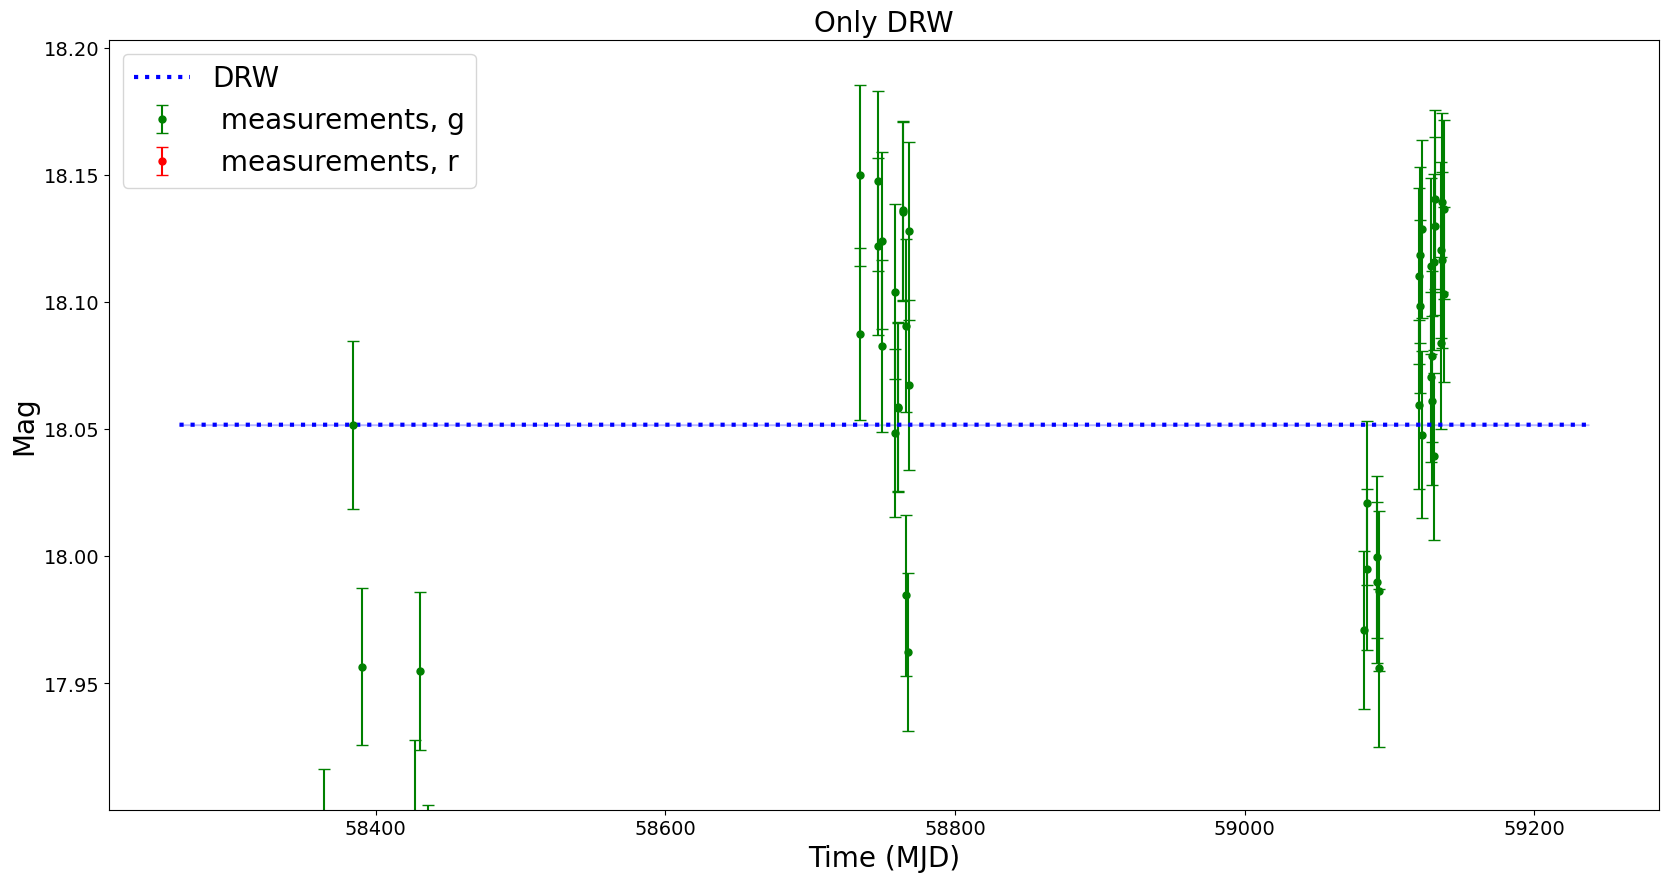

In [15]:
plt.figure(figsize=(20, 10))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=4, label = ' measurements, g', ms=10, color = 'green')
plt.errorbar(t_r, y_r, yerr=yerr_r, fmt=".k", capsize=4, label = ' measurements, r', ms=10, color = 'red')

plt.fill_between(x, mu_drw + np.sqrt(var_drw), mu_drw - np.sqrt(var_drw), color="blue", alpha=0.2)
plt.plot(x, mu_drw, color="blue", lw=3, ls=':', label = 'DRW')

plt.xlabel("Time (MJD)", fontsize=20)
plt.ylabel("Mag", fontsize=20)
plt.legend(fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(np.min(mu)-0.1, np.max(mu)+0.1)
plt.title('Only DRW',  fontsize=20)